# ZARR compression on experimental Neuropixels data

This notebook investigaes the use of Zarr compressors and filters to compress raw Neuropixels data.

In particular it covers:

- effect of LSB division on CR
- bit truncation
   - effect on spike sorting
   - effect on waveforms features

In [1]:
import spikeinterface.full as si
import spikeinterface.sortingcomponents as scp

import probeinterface as pi
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import os
import time
from pathlib import Path
import time
import shutil
import pandas as pd
import seaborn as sns

import zarr
import numcodecs
from numcodecs import Blosc, Zstd, blosc


%matplotlib widget

/home/alessio/anaconda3/envs/si/lib/python3.9/site-packages/datalad/cmd.py:375: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  new_loop = True
/home/alessio/Documents/codes/spike_sorting/spikeinterface/spikeinterface/spikeinterface/core/datasets.py:12: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  HAVE_DATALAD = False


In [2]:
job_kwargs = dict(n_jobs=20, chunk_duration="1s", progress_bar=True)

### Choose overwrite option

In [3]:
overwrite = False

In [4]:
zarr_output_folder = Path("zarr_tests")

if overwrite:
    if zarr_output_folder.is_dir():
        shutil.rmtree(zarr_output_folder)

    zarr_output_folder.mkdir()

## Load open-ephys data in SpikeInterface


In [5]:
data_folder = Path("/home/alessio/Documents/data/allen/npix-open-ephys/")

In [7]:
np_version = 1

In [8]:
if np_version == 1:
    oe_folder = data_folder / "618382_2022-03-31_14-27-03/Record Node 102/" # NP1.0
else:
    oe_folder = data_folder / "595262_2022-02-22_16-47-26/Record Node 102/" # NP2.0

rec_full = si.read_openephys(oe_folder, stream_id="0")
print(rec_full)

OpenEphysBinaryRecordingExtractor: 384 channels - 2 segments - 30.0kHz - 1283.137s


In [9]:
# rec_full = si.read_spikeglx("/home/alessio/Documents/data/gin/ephy_testing_data/spikeglx/Noise4Sam_g0",
#                             stream_id="imec0.ap")

In [10]:
rec_full = si.split_recording(rec_full)[0]

In [11]:
rec_full

SelectSegmentRecording: 384 channels - 1 segments - 30.0kHz - 770.414s

(-20.0, 80.0)

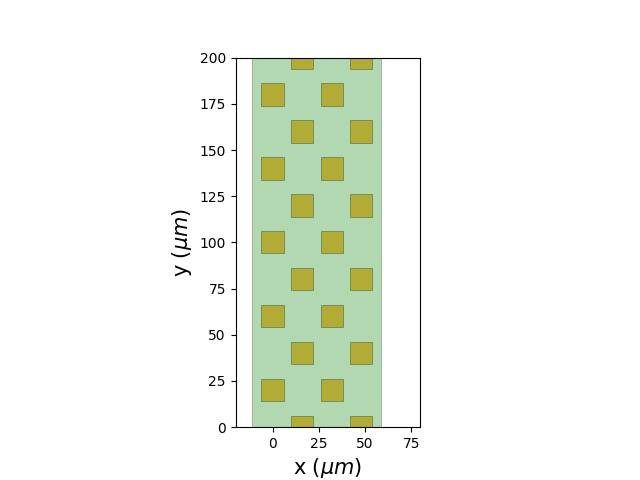

In [12]:
w = si.plot_probe_map(rec_full)
w.ax.set_ylim(0, 200)
w.ax.set_xlim(-20, 80)

(Optional) Remove channels outside of the brain (so far, from visual inspection)

In [ ]:
w = si.plot_timeseries(rec_full, time_range=[100, 110], show_channel_ids=True)

In [ ]:
# remove channels outside
# rec = rec_full.channel_slice(channel_ids=rec_full.channel_ids[:-120])

### Check different CMR strategies using peak detection

In [ ]:
rec_f = si.bandpass_filter(rec_full)
rec_cmr_g = si.common_reference(rec_f)
rec_cmr_l = si.common_reference(rec_f, reference="local")

In [ ]:
# w = si.plot_timeseries(rec, time_range=[100, 105])
peaks = scp.detect_peaks(rec_full, **job_kwargs)
peaks_cmr_g = scp.detect_peaks(rec_cmr_g, **job_kwargs)
peaks_cmr_l = scp.detect_peaks(rec_cmr_l, **job_kwargs)

In [ ]:
si.plot_drift_over_time(rec_full, peaks, mode="scatter")
si.plot_drift_over_time(rec_cmr_g, peaks_cmr_g, mode="scatter")
si.plot_drift_over_time(rec_cmr_l, peaks_cmr_l, mode="scatter")

In [ ]:
fig, axs = plt.subplots(nrows=3, sharex=True)
w = si.plot_timeseries(rec, time_range=[197, 198], show_channel_ids=True, mode="line",
                       channel_ids=rec.channel_ids[::20], ax=axs[0])
w = si.plot_timeseries(rec_cmr_g, time_range=[197, 198], show_channel_ids=True, mode="line",
                       channel_ids=rec_cmr_g.channel_ids[::20], ax=axs[1])
w = si.plot_timeseries(rec_cmr_l, time_range=[197, 198], show_channel_ids=True, mode="line",
                       channel_ids=rec_cmr_l.channel_ids[::20], ax=axs[2])

In [21]:
rec = rec_full

Local CMR seems to provide better preprocessing output!

## Correct for LSB

NP1.0 should have a 10-bit ADC, NP2.0 should have 14-bit ADC

In [23]:
if np_version == 1:
    nbits = 10
else:
    nbits = 14

In [24]:
max_ptp_i2 = 0

for i in range(10):
    chunks_i2 = si.get_random_data_chunks(rec, seed=i**2)
    
    if np.ptp(chunks_i2) > max_ptp_i2:
        max_ptp_i2 = np.ptp(chunks_i2)
print(f"Num bits ptp: {int(np.ceil(np.log2(max_ptp_i2)))}")  

Num bits ptp: 14


In [25]:
# gather chunks
lsb = 0
num_random_chunks = 5
chunks = None
for i in tqdm(range(num_random_chunks), desc="Extracting chunks"):
    chunks_i2 = si.get_random_data_chunks(rec, chunk_size=30000, seed=i**2)
    if chunks is None:
        chunks = chunks_i2
    else:
        chunks = np.vstack((chunks, chunks_i2))

Extracting chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.66it/s]


In [26]:
lsb = 0

num_channels = rec.get_num_channels()
gain = rec.get_channel_gains()[0]
dtype = rec.get_dtype()

channel_idxs = np.arange(num_channels)
min_values = np.zeros(num_channels, dtype=dtype)
median_values = np.zeros(num_channels, dtype=dtype)
offsets = np.zeros(num_channels, dtype=dtype)

for ch in tqdm(channel_idxs, desc="Estimating channel stats"):
    unique_vals = np.unique(chunks[:, ch])
    unique_vals_abs = np.abs(unique_vals)
    lsb_ = np.min(np.diff(unique_vals))
    
    min_values[ch] = np.min(unique_vals_abs)
    median_values[ch] = np.median(chunks[:, ch]).astype(dtype)
    
    unique_vals_m = np.unique(chunks[:, ch] - median_values[ch])
    unique_vals_abs_m = np.abs(unique_vals_m)
    offsets[ch] = np.min(unique_vals_abs_m)
    
    if lsb_ > lsb:
        lsb = lsb_

print(f"LSB int16 {lsb} --> {lsb * gain} uV")

Estimating channel stats: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384/384 [00:57<00:00,  6.68it/s]

LSB int16 12 --> 2.339999914169311 uV


In [39]:
# for ch in channel_idxs:
#     if np.ptp(chunks[:, ch]) > lsb * (2 ** nbits):
#         print("Channel", ch, np.ptp(chunks[:, ch]), lsb * (2 ** nbits))

In [ ]:
print(f"PTP: {np.ptp(chunks)} -- ADC Range: {lsb * (2 ** nbits)}")
assert np.ptp(chunks) <= lsb * (2 ** nbits)

In [29]:
print(f"Num bits ptp after lsb division: {int(np.ceil(np.log2(np.ptp(chunks / lsb))))}")

Num bits ptp after lsb division: 11


In [ ]:
lsb_all = np.min(np.diff(np.sort(np.unique(chunks.ravel()))))
print(lsb_all)

**Note:** for NP1.0 LSB computed by channel and computed on the concatenated signal differ, probably due to some small offsets in the ADC (try to compute it by ADC). For NP2.0, channel-wise LSB and global LSB are the same (3) 

### Truncation filter 

Optional truncation filter function (modified from [here](https://github.com/AllenNeuralDynamics/lightsheet-compression-tests/blob/main/compress_zarr.py#L18))

In [79]:
def trunc_filter(bits, recording, encoded_dtype=None):
    scale = 1.0 / (2 ** bits)
    if encoded_dtype is None:
        encoded_dtype = recording.get_dtype()
    dtype = recording.get_dtype()
    if bits == 0:
        return []
    else:
        return [numcodecs.fixedscaleoffset.FixedScaleOffset(offset=0, scale=scale, dtype=dtype,
                                                            astype=encoded_dtype)]

### Choose zarr compressor

`zstd` seems to provide good compression ratios and comp-/decomp speeds. 
Let's choose a middle level (e.g. 5)

In [68]:
clevel = 9

In [15]:
compressor = Blosc(cname='zstd', clevel=clevel, shuffle=Blosc.BITSHUFFLE,)

### Define output folder and configs

In [16]:
zarr_root = f"test_npix{np_version}_full_zarr"

In [17]:
# zarr_root = f"test_spikeglx{np_version}_full_zarr"

In [18]:
# define truncation bits
trunc_bits = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# optionally define stub as the number of seconds to cut the recording (e.g. stub = 30)
stub = None

In [19]:
blosc.use_threads = True

## INT8 for NP1.0 (but trunc 2)

In [69]:
if stub is not None:
    end_frame = int(stub * rec.get_sampling_frequency())
    rec_stub = rec.frame_slice(start_frame=0, end_frame=end_frame)
else:
    rec_stub = rec

In [86]:
trunc_bit = 3
overwrite = True

In [80]:
rec_stub_r = si.scale(rec_stub, gain=1., offset=-median_values, dtype="int16")
rec_stub_r = si.scale(rec_stub_r, gain=1. / lsb, dtype="int16")

zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_int16_LSB.zarr"
if overwrite:
    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)

t_start = time.perf_counter()
# first apply offset, then lsb
filters = trunc_filter(trunc_bit, rec_stub_r)
print(filters)
rec_zarr_int16 = rec_stub_r.save(format="zarr", zarr_path=zarr_path, 
                                 compressor=compressor, filters=filters, 
                                 **job_kwargs)
cr_int16 = rec_zarr_int16.get_annotation("compression_ratio")
rec_zarr_int16.set_channel_gains(rec_zarr_int16.get_channel_gains() * lsb)

t_stop = time.perf_counter()
elapsed_time = np.round(t_stop - t_start, 2)
print(f"Elapsed time truncation: {trunc_bit} - INT16: {elapsed_time}s - CR: {cr_int16}")

[FixedScaleOffset(scale=0.25, offset=0, dtype='<i2')]
write_zarr_recording with n_jobs 20  chunk_size 30000


write_zarr_recording: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [03:36<00:00,  3.56it/s]

Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized
Elapsed time truncation: 2 - INT16: 217.63s - CR: 5.211028530412864


In [81]:
filters = trunc_filter(trunc_bit, rec_stub_r, encoded_dtype="int8")

In [82]:
zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_int8_LSB.zarr"
if overwrite:
    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)
t_start = time.perf_counter()

dtype = "int8"

# first apply offset, then lsb
# filters = trunc_filter(trunc_bit, rec_stub_r, dtype=dtype)
print(filters)
rec_zarr_int8 = rec_stub_r.save(format="zarr", zarr_path=zarr_path, 
                                compressor=compressor, filters=filters, 
                                **job_kwargs)
cr_int8 = rec_zarr_int8.get_annotation("compression_ratio")
rec_zarr_int8.set_channel_gains(rec_zarr_int8.get_channel_gains() * lsb)

t_stop = time.perf_counter()
elapsed_time = np.round(t_stop - t_start, 2)
print(f"Elapsed time truncation: {trunc_bit} - INT8: {elapsed_time}s - CR: {cr_int8}")

[FixedScaleOffset(scale=0.25, offset=0, dtype='<i2', astype='|i1')]
write_zarr_recording with n_jobs 20  chunk_size 30000


write_zarr_recording: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [02:34<00:00,  5.01it/s]


Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized
Elapsed time truncation: 2 - INT8: 154.7s - CR: 5.2826502609017885


In [83]:
rec_zarr_int16._recording_segments[0]._timeseries.info

Name,/traces_seg0
Type,zarr.core.Array
Data type,int16
Shape,"(23112408, 384)"
Chunk shape,"(30000, 384)"
Order,C
Read-only,True
Filter [0],"FixedScaleOffset(scale=0.25, offset=0, dtype='<i2')"
Compressor,"Blosc(cname='zstd', clevel=9, shuffle=BITSHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,17750329344 (16.5G)


In [84]:
rec_zarr_int8._recording_segments[0]._timeseries.info

Name,/traces_seg0
Type,zarr.core.Array
Data type,int16
Shape,"(23112408, 384)"
Chunk shape,"(30000, 384)"
Order,C
Read-only,True
Filter [0],"FixedScaleOffset(scale=0.25, offset=0, dtype='<i2', astype='|i1')"
Compressor,"Blosc(cname='zstd', clevel=9, shuffle=BITSHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,17750329344 (16.5G)


In [45]:
rec_zarr_int8.get_traces(end_frame=10).dtype

dtype('int16')

In [38]:
rec_zarr_rescale_m.get_annotation("compression_ratio")

3.131157927467099

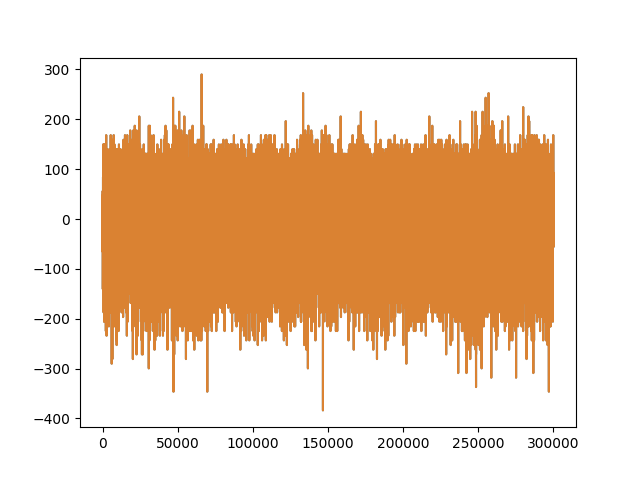

In [85]:
start_frame = int(30*30000)
end_frame = int(40*30000)

channel_id = rec_zarr_int16.channel_ids[200]

tr_int16 = rec_zarr_int16.get_traces(start_frame=start_frame, end_frame=end_frame,
                                     channel_ids=[channel_id], return_scaled=True)
tr_int8 = rec_zarr_int8.get_traces(start_frame=start_frame, end_frame=end_frame,
                                   channel_ids=[channel_id], return_scaled=True)

plt.figure()
plt.plot(tr_int16, alpha=0.8)
plt.plot(tr_int8, alpha=0.8)

## Does LSB division improve CR?

Here we first try if dividing by the LSB (hence shifting the int16 encoding "to the right") improves lossless compression ratio:

In [24]:
stub = 30

In [25]:
if stub is not None:
    end_frame = int(stub * rec.get_sampling_frequency())
    rec_stub = rec.frame_slice(start_frame=0, end_frame=end_frame)
else:
    rec_stub = rec

In [26]:
trunc_bit = 0

In [27]:
overwrite = True

In [ ]:
zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_nolsb.zarr"
if overwrite:
    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)

t_start = time.perf_counter()
filters = []
rec_zarr_nolsb = rec_stub.save(format="zarr", zarr_path=zarr_path, 
                               compressor=compressor, filters=filters, 
                               **job_kwargs)
t_stop = time.perf_counter()
elapsed_time = np.round(t_stop - t_start, 2)
cr_nolsb = np.round(rec_zarr_nolsb._root['traces_seg0'].nbytes / rec_zarr_nolsb._root['traces_seg0'].nbytes_stored, 2)
print(f"Elapsed time truncation: {trunc_bit} - no LSB division: {elapsed_time}s - CR: {cr_nolsb}")

# try rescale in SI - MIN value
zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_lsb_rescale.zarr"
if overwrite:
    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)
t_start = time.perf_counter()
# first apply offset, then lsb
rec_stub_r = si.scale(rec_stub, gain=1., offset=-min_values, dtype="int16")
rec_stub_r = si.scale(rec_stub_r, gain=1. / lsb, dtype="int16")
filters = []
rec_zarr_rescale = rec_stub_r.save(format="zarr", zarr_path=zarr_path, 
                                   compressor=compressor, filters=filters, 
                                   **job_kwargs)
cr_lsb_r = np.round(rec_zarr_rescale._root['traces_seg0'].nbytes / rec_zarr_rescale._root['traces_seg0'].nbytes_stored, 2)
rec_zarr_rescale = si.scale(rec_zarr_rescale, gain=lsb, dtype="int16")
rec_zarr_rescale = si.scale(rec_zarr_rescale, offset=min_values, dtype="int16")
t_stop = time.perf_counter()
elapsed_time = np.round(t_stop - t_start, 2)
print(f"Elapsed time truncation: {trunc_bit} - LSB pre-scale: {elapsed_time}s - CR: {cr_lsb_r}")


# try rescale in SI - MEDIAN + MINVALUE value
zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_lsb_rescale.zarr"
if overwrite:
    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)
t_start = time.perf_counter()
# first apply offset, then lsb
rec_stub_r = si.scale(rec_stub, gain=1., offset=-median_values, dtype="int16")
rec_stub_r = si.scale(rec_stub_r, gain=1. / lsb, dtype="int16")
filters = []
rec_zarr_rescale_m = rec_stub_r.save(format="zarr", zarr_path=zarr_path, 
                                     compressor=compressor, filters=filters, 
                                     **job_kwargs)
cr_lsb_rm = np.round(rec_zarr_rescale_m._root['traces_seg0'].nbytes / rec_zarr_rescale_m._root['traces_seg0'].nbytes_stored, 2)
rec_zarr_rescale_m = si.scale(rec_zarr_rescale_m, gain=lsb, dtype="int16")
rec_zarr_rescale_m = si.scale(rec_zarr_rescale_m, offset=median_values, dtype="int16")
t_stop = time.perf_counter()
elapsed_time = np.round(t_stop - t_start, 2)
print(f"Elapsed time truncation: {trunc_bit} - LSB pre-scale median: {elapsed_time}s - CR: {cr_lsb_rm}")

## Doeas DELTA improve CR?

In [18]:
filters = [numcodecs.Delta(dtype=rec.get_dtype())]

In [19]:
job_kwargs = dict(n_jobs=1, chunk_duration="1s", progress_bar=True)

In [28]:
zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_delta.zarr"
if overwrite:
    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)
rec_zarr_d = rec_stub.save(format="zarr", zarr_path=zarr_path, 
                           compressor=compressor, filters=filters, 
                           **job_kwargs)

write_zarr_recording with n_jobs 1  chunk_size 30000


write_zarr_recording: 100%|#######################################################################################################################################################################################################################| 30/30 [00:08<00:00,  3.61it/s]

Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized


In [29]:
numcodecs.__file__

'/home/alessio/anaconda3/envs/si/lib/python3.9/site-packages/numcodecs/__init__.py'

In [ ]:
# # try rescale in SI - MEDIAN + MINVALUE value
# zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_nodelta.zarr"
# if overwrite:
#     if zarr_path.is_dir():
#         shutil.rmtree(zarr_path)
# t_start = time.perf_counter()
# # first apply offset, then lsb
# rec_stub_r = si.scale(rec_stub, gain=1., offset=-median_values, dtype="int16")
# rec_stub_r = si.scale(rec_stub_r, gain=1. / lsb, dtype="int16")
# rec_zarr_rescale_m = rec_stub_r.save(format="zarr", zarr_path=zarr_path, 
#                                      compressor=compressor, filters=[], 
#                                      **job_kwargs)
# cr_lsb_rm = np.round(rec_zarr_rescale_m._root['traces_seg0'].nbytes / rec_zarr_rescale_m._root['traces_seg0'].nbytes_stored, 2)
# rec_zarr_rescale_m = si.scale(rec_zarr_rescale_m, gain=lsb, dtype="int16")
# rec_zarr_rescale_m = si.scale(rec_zarr_rescale_m, offset=median_values, dtype="int16")
# t_stop = time.perf_counter()
# elapsed_time = np.round(t_stop - t_start, 2)
# print(f"Elapsed time truncation: {trunc_bit} - LSB - no DELTA: {elapsed_time}s - CR: {cr_lsb_rm}")


# try rescale in SI - MEDIAN + MINVALUE value
zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}_delta.zarr"
if overwrite:
    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)
t_start = time.perf_counter()
# first apply offset, then lsb
rec_stub_r = si.scale(rec_stub, gain=1., offset=-median_values, dtype="int16")
rec_stub_r = si.scale(rec_stub_r, gain=1. / lsb, dtype="int16")
rec_zarr_rescale_d = rec_stub_r.save(format="zarr", zarr_path=zarr_path, 
                                     compressor=compressor, filters=filters, 
                                     **job_kwargs)
cr_lsb_rd = np.round(rec_zarr_rescale_d._root['traces_seg0'].nbytes / rec_zarr_rescale_d._root['traces_seg0'].nbytes_stored, 2)
rec_zarr_rescale_d = si.scale(rec_zarr_rescale_d, gain=lsb, dtype="int16")
rec_zarr_rescale_d = si.scale(rec_zarr_rescale_d, offset=median_values, dtype="int16")
t_stop = time.perf_counter()
elapsed_time = np.round(t_stop - t_start, 2)
print(f"Elapsed time truncation: {trunc_bit} - LSB - DELTA: {elapsed_time}s - CR: {cr_lsb_rd}")

## Benchmark bit truncation on traces and spike sorting

In [ ]:
overwrite = True

In [ ]:
trunc_bits = [0, 1, 2, 4, 5, 6, 7, 8]

In [ ]:
rec_zarr_df = None

for trunc_bit in trunc_bits:
    zarr_path = zarr_output_folder / f"{zarr_root}_trunc{trunc_bit}.zarr"

    if overwrite:
        if zarr_path.is_dir():
            shutil.rmtree(zarr_path)

    if stub is not None:
        end_frame = int(stub * rec.get_sampling_frequency())
        rec_stub = rec.frame_slice(start_frame=0, end_frame=end_frame)
    else:
        rec_stub = rec

    if zarr_path.is_dir():
        rec_zarr = si.read_zarr(zarr_path)
        elapsed_time = 0
    else:
        t_start = time.perf_counter()
        filters = trunc_filter(trunc_bit, rec_stub)

        # median correction
        rec_to_compress = si.scale(rec_stub, gain=1., offset=-median_values, dtype="int16")
        rec_to_compress = si.scale(rec_to_compress, gain=1. / lsb, dtype="int16")

        rec_zarr = rec_stub.save(format="zarr", zarr_path=zarr_path, 
                                 compressor=compressor, filters=filters, 
                                 **job_kwargs)
        rec_to_decompress = si.scale(rec_zarr, gain=lsb, dtype="int16")
        rec_to_decompress = si.scale(rec_to_decompress, offset=median_values, 
                                     dtype="int16")
        t_stop = time.perf_counter()
        elapsed_time = np.round(t_stop - t_start, 2)
    cr = np.round(rec_zarr._root['traces_seg0'].nbytes / rec_zarr._root['traces_seg0'].nbytes_stored, 2)

    rec_to_decompress_f = si.bandpass_filter(rec_to_decompress)
    out_dict = {"trunc_bit": trunc_bit, "CR": cr, "rec": rec_to_decompress, "rec_f": rec_f}

    df = pd.DataFrame(out_dict)
    if rec_zarr_df is None:
        rec_zarr_df = df
    else:
        rec_zarr_df = pd.concat([rec_zarr_df, df])


    print(f"Elapsed time truncation: {trunc_bit}: {elapsed_time}s - CR: {cr}")

### Visualization

In [ ]:
time_range = [15, 15.2]
channel_ids = rec.get_channel_ids()[100:110]

In [ ]:
fig_ts, axs_ts = plt.subplots(nrows=2, sharex=True)
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    rec_trunc_nolsb = trunc_dict["nolsb"]["rec"]
    rec_trunc_lsb = trunc_dict["lsb"]["rec"]

    _ = si.plot_timeseries(rec_trunc_nolsb, time_range=time_range, channel_ids=channel_ids,
                           mode="line", color=f"C{i}", ax=axs_ts[0])
    l = axs_ts[0].get_lines()[-1].set_label(f"trunc {trunc_bits[i]} - nolsb")

    _ = si.plot_timeseries(rec_trunc_nolsb, time_range=time_range, channel_ids=channel_ids,
                           mode="line", color=f"C{i}", ax=axs_ts[0], ls="--")
    l = axs_ts[0].get_lines()[-1].set_label(f"trunc {trunc_bits[i]} - lsb")


    rec_f_nolsb = si.bandpass_filter(rec_trunc_nolsb)
    rec_f_lsb = si.bandpass_filter(rec_trunc_lsb)

    rec_zarr_dict[trunc_bit]["nolsb"]["rec_filt"] = rec_f_nolsb
    rec_zarr_dict[trunc_bit]["lsb"]["rec_filt"] = rec_f_lsb

    _ = si.plot_timeseries(rec_f_nolsb, time_range=time_range, channel_ids=channel_ids,
                           mode="line", color=f"C{i}", ax=axs_ts[1])
    _ = si.plot_timeseries(rec_f_lsb, time_range=time_range, channel_ids=channel_ids,
                           mode="line", color=f"C{i}", ax=axs_ts[1], ls="--")
axs_ts[0].legend()
axs_ts[0].set_title("Raw", fontsize=15)
axs_ts[0].set_xlabel("", fontsize=15)
axs_ts[1].set_title("Filtered", fontsize=15)
fig_ts.subplots_adjust(hspace=0.3)

### RMS error on filtered traces

In [ ]:
time_range = [15, 18]
frames = np.array(time_range) * rec.get_sampling_frequency()
frames = frames.astype(int)

In [ ]:
rec_orig_f = si.bandpass_filter(rec_stub)
traces_orig = rec_orig_f.get_traces(start_frame=frames[0], end_frame=frames[1], return_scaled=True)
errors_rms = []
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    for lsb_cor in trunc_dict:
        rec_f = trunc_dict[lsb_cor]["rec_filt"]
        traces_trunc_f = rec_f.get_traces(start_frame=frames[0], end_frame=frames[1], return_scaled=True)

        error_rms = np.sqrt(((traces_trunc_f.ravel() - traces_orig.ravel()) ** 2).mean())
        rec_zarr_dict[trunc_bit][lsb_cor]["rmse"] = error_rms
        print(f"RMS for truncation {trunc_bit} - lsb {lsb_cor}: {np.round(error_rms, 4)} uV")

In [ ]:
# fig_e, ax_e = plt.subplots()
# ax_cr = ax_e.twinx()

trunc_bit_array = []
errors_rms_array = []
crs_array = []
lsb_array = []


for (trunc_bit, trunc_dict) in rec_zarr_dict.items():
    for lsb_cor in trunc_dict: 
        trunc_bit_array.append(trunc_bit)
        lsb_array.append(lsb_cor == "lsb")
        crs_array.append(trunc_dict[lsb_cor]["CR"])
        errors_rms_array.append(trunc_dict[lsb_cor]["rmse"])


df = pd.DataFrame({"trunc_bit": trunc_bit_array, "lsb": lsb_array,
                   "CR": crs_array, "rmse": errors_rms_array})

plt.figure()
sns.pointplot(data=df, x="trunc_bit", y="CR", hue="lsb")
plt.figure()
sns.pointplot(data=df, x="trunc_bit", y="rmse", hue="lsb")
        
# ax_e.plot(trunc_bits, errors_rms, "d",
#           ls="--", label="RMSE")
# ax_cr.plot(trunc_bits, crs, "o",
#            ls="-", color="C1", label="CR")

# ax_e.set_title("Error VS CR")
# ax_e.set_xlabel("# truncation bits")
# ax_e.set_ylabel("Error rms $\mu$V")
# ax_cr.set_ylabel("CR")
# ax_e.axhline(1, color="C0", ls="--", alpha=0.4)
# ax_cr.axhline(3, color="C1", ls="--", alpha=0.4)
# ax_e.spines['left'].set_color('C0')
# ax_cr.spines['left'].set_color('C0')
# ax_cr.spines['right'].set_color('C1')
# ax_e.yaxis.label.set_color('C0')
# ax_cr.yaxis.label.set_color('C1')
# ax_e.tick_params(axis='y', colors='C0')
# ax_cr.tick_params(axis='y', colors='C1')
# ax_e.spines['top'].set_visible(False)
# ax_cr.spines['top'].set_visible(False)


# ax_e.legend()

## Spike Sorting

Test whether compression affects spike sorting results.

In [ ]:
si.installed_sorters()

In [ ]:
sorter = "tridesclous"

In [ ]:
for (trunc_bit, trunc_dict) in rec_zarr_dict.items():
    print(f"Running {sorter} for truncation bits {trunc_bit}")
    
    sorter_folder = zarr_output_folder / f"{sorter}_trunc{trunc_bit}"
    if sorter_folder.is_dir() and not overwrite:
        sort = si.load_extractor(sorter_folder)
    else:
        rec_f = trunc_dict["rec_filt"]
        rec_cmr = si.common_reference(rec_f, operator="median", reference="global")
        t_start = time.perf_counter()
        sort = si.run_sorter(sorter, rec_f, verbose=True)
        sort = sort.save(folder=zarr_output_folder / f"{sorter}_trunc{trunc_bit}")
        t_stop = time.perf_counter()
        elapsed_time = np.round(t_stop - t_start, 2)
    rec_zarr_dict[trunc_bit]["sort"] = sort
    
    
    print(f"Elapsed {sorter} - truncation {trunc_bit}: {elapsed_time}s -- num units: {len(sort.unit_ids)}")

### Spike sorting comparison

In [ ]:
# compare to lossless case
gt_sorting = rec_zarr_dict[0]["sort"]

In [ ]:
fig_st, ax_st = plt.subplots()
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    if "sort" in trunc_dict:
        sort = trunc_dict["sort"]
        w = si.plot_rasters(sort, ax=ax_st, color=f"C{i}")
        ax_st.get_lines()[-1].set_label(f"Trunc. bits: {trunc_bit}")
    else:
        print(f"Missing sorting object for trunc. bits: {trunc_bit}")

In [ ]:
sortings = []
for (trunc_bit, trunc_dict) in rec_zarr_dict.items():
    if trunc_bit == 0:
        rec_zarr_dict[trunc_bit]["cmp"] = None
    else:
        if "sort" in trunc_dict:
            sort = trunc_dict["sort"]
            cmp = si.compare_sorter_to_ground_truth(gt_sorting, sort)
            rec_zarr_dict[trunc_bit]["cmp"] = cmp

            print(f"\n\n\nTrunc bits: {trunc_bit}")
            cmp.print_performance()
            sortings.append(sort)
        else:
            print(f"Missing sorting object for trunc. bits: {trunc_bit}")

In [ ]:
# fig_cmp, axs = plt.subplots(nrows=len(trunc_bits) - 1)

for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    if i != 0:
        if "cmp" in trunc_dict:
            cmp = trunc_dict["cmp"]
            w = si.plot_agreement_matrix(cmp)
            w.ax.set_title(f"Bits truncated: {trunc_bit}", fontsize=15)
        else:
            print(f"Missing comparison object for trunc. bits: {trunc_bit}")

In [ ]:
mcmp = si.compare_multiple_sorters([gt_sorting] + sortings, name_list=[f"Trunc{t}" for t in trunc_bits])

In [ ]:
si.plot_multicomp_graph(mcmp)

In [ ]:
si.plot_multicomp_agreement(mcmp)

fig_mcmp, axs_mcmcp = plt.subplots(ncols=3, nrows=3)
si.plot_multicomp_agreement_by_sorter(mcmp, axes=axs_mcmcp.ravel())
# si.plot_multicomp_graph(mcmp)

In [ ]:
min_agreement_count = 9

In [ ]:
sorting_agreement = mcmp.get_agreement_sorting(minimum_agreement_count=min_agreement_count)
sorting_agreement

In [ ]:
sorting_agreement = sorting_agreement.save(folder=zarr_output_folder / f"{sorter}_agreement_all")

In [ ]:
we_bit0 = si.extract_waveforms(gt_recording, rec_zarr_dict[0]["sort"], folder=wfs_folder / "wf_lossless_0",
                               overwrite=True, **job_kwargs)

In [ ]:
si.plot_unit_templates(we_bit0, unit_ids=[we_bit0.sorting.unit_ids[0]])

### Template comparison

In [ ]:
wfs_folder = zarr_output_folder / f"wfs_{sorter}"
wfs_folder.mkdir(exist_ok=True)

In [ ]:
gt_recording = rec_zarr_dict[0]["rec_filt"]
we_gt = si.extract_waveforms(gt_recording, sorting_agreement, folder=wfs_folder / "wf_lossless",
                             overwrite=True, **job_kwargs)
gt_templates = we_gt.get_all_templates()
rec_zarr_dict[0]["we"] = we_gt
rec_zarr_dict[0]["templates"] = gt_templates

In [ ]:
query_auto_curation = 

In [ ]:
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    if i != 0:
        recording = rec_zarr_dict[trunc_bit]["rec_filt"]
        we = si.extract_waveforms(recording, sorting_agreement, folder=wfs_folder / f"wf_{trunc_bit}",
                                  overwrite=True, **job_kwargs)
        templates = we.get_all_templates()
        rec_zarr_dict[trunc_bit]["we"] = we
        rec_zarr_dict[trunc_bit]["templates"] = templates

In [ ]:
# plot all units
fig_all, ax_all = plt.subplots()
_ = si.plot_unit_templates(we_gt, radius_um=radius_um, axes=[ax_all] * len(sorting_agreement.unit_ids))

In [ ]:
sorting_agreement.unit_ids

In [ ]:
unit_id = 4
radius_um = 300

In [ ]:
fig_wf, ax_wf = plt.subplots()

_ = si.plot_unit_templates(we_gt, unit_ids=[unit_id], radius_um=radius_um, 
                           unit_colors={unit_id: f"C0"}, axes=[ax_wf])
ax_wf.get_lines()[-1].set_label(f"Trunc. bits: 0")

for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    if i != 0:
        we = rec_zarr_dict[trunc_bit]["we"]
        _ = si.plot_unit_templates(we, unit_ids=[unit_id], radius_um=radius_um, 
                                   unit_colors={unit_id: f"C{i}"}, axes=[ax_wf])
        ax_wf.get_lines()[-1].set_label(f"Trunc. bits: {trunc_bit}")
ax_wf.legend()

### Absolute errors

In [ ]:
max_template_errors = []
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    templates = rec_zarr_dict[trunc_bit]["templates"]
    max_template_error = np.max(np.abs(templates - gt_templates))
    max_template_errors.append(max_template_error)
    
fig_temp_e, ax_temp_e = plt.subplots()
ax_temp_cr = ax_e.twinx()


ax_temp_e.plot(trunc_bits, max_template_errors, "d",
               ls="--", label="RMSE")
ax_temp_cr.plot(trunc_bits, crs, "o",
                ls="-", color="C1", label="CR")

ax_temp_e.set_title("Template error VS CR")
ax_temp_e.set_xlabel("# truncation bits")
ax_temp_e.set_ylabel("Error rms $\mu$V")
ax_temp_cr.set_ylabel("CR")
ax_temp_e.axhline(1, color="C0", ls="--", alpha=0.4)
ax_temp_cr.axhline(3, color="C1", ls="--", alpha=0.4)
ax_temp_e.spines['left'].set_color('C0')
ax_temp_cr.spines['left'].set_color('C0')
ax_temp_cr.spines['right'].set_color('C1')
ax_temp_e.yaxis.label.set_color('C0')
ax_temp_cr.yaxis.label.set_color('C1')
ax_temp_e.tick_params(axis='y', colors='C0')
ax_temp_cr.tick_params(axis='y', colors='C1')
ax_temp_e.spines['top'].set_visible(False)
ax_temp_cr.spines['top'].set_visible(False)

In [ ]:
plt.figure()

trunc_bit = 5
temp_idx = 4

gt_temp = gt_templates[temp_idx]
tested_temp = rec_zarr_dict[trunc_bit]["templates"][temp_idx]

temp_abs_dist = np.abs(gt_temp - tested_temp)

max_error_samp, max_error_chan = np.unravel_index(np.argmax(temp_abs_dist), temp_abs_dist.shape)

print(f"Max error uV: {np.max(temp_abs_dist)}")

_ = plt.plot(gt_temp, color="C0")
_ = plt.plot(tested_temp, color="C1", alpha=0.5)
plt.plot([max_error_samp] * 2, [gt_temp[max_error_samp, max_error_chan], 
                                tested_temp[max_error_samp, max_error_chan]], 
         color="r", marker="*", ls="--", markersize=5)
plt.legend()
plt.xlabel("# samples")
plt.ylabel("voltage ($\mu$V)")

In [ ]:
si.get_template_metric_names()

In [ ]:
# compute template metrics
df_tm = None
for i, (trunc_bit, trunc_dict) in enumerate(rec_zarr_dict.items()):
    we = trunc_dict["we"]
    tm = si.calculate_template_metrics(we, upsample=10)
    tm["trunc_bits"] = [trunc_bit] * len(tm)
    tm["unit_id"] = tm.index
    if df_tm is None:
        df_tm = tm
    else:
        df_tm = pd.concat([df_tm, tm], ignore_index=True)

In [ ]:
df_tm

In [ ]:
df_tm.query("unit_id == 10")

In [ ]:
ax.legend?

In [ ]:
fig, ax_ptp = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_tm, x="peak_to_valley", y="half_width", hue="trunc_bits",
                style="unit_id", palette="tab20", ax=ax_ptp)
ax_ptp.get_figure().legend(bbox_to_anchor=(0.1, 1.02, 0.2, 1), ncol=len(trunc_bits))


In [ ]:
fig, ax_ptp = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df_tm, x="repolarization_slope", y="recovery_slope", hue="trunc_bits",
                style="unit_id", palette="tab20", ax=ax_ptp)
ax_ptp.get_figure().legend(bbox_to_anchor=(0.1, 1.02, 0.2, 1), ncol=len(trunc_bits))


In [ ]:
import sys
sys.path.append("..")

In [ ]:
from correct_open_ephys_settings import correct_open_ephys_settings

oe_folder = "/home/alessio/Documents/data/allen/npix-open-ephys/605068_2022-03-04_15-06-32/Record Node 102"

In [ ]:
correct_open_ephys_settings(oe_folder)

In [ ]:
import spikeinterface.full as si
from numcodecs import Blosc

rec_oe = si.read_openephys("path-to-oe-folder")

compressor = Blosc(cname='zstd', clevel=clevel, shuffle=Blosc.BITSHUFFLE)

rec_zarr = rec_oe.save(format="zarr", zarr_path="outout.zarr", 
                       compressor=compressor, n_jobs=20, chunk_duration="1s")

In [ ]:
import numcodecs
import numpy as np
nsamples = 500
stride = 2
nchans = 5
x = np.arange(0, nsamples, stride, dtype='i8')
x = x.reshape(len(x) // nchans, nchans)
codec = numcodecs.Delta(dtype='i8', astype='i1')
y = codec.encode(x)
print(y)
z = codec.decode(y)
print(z)


In [ ]:
nsamples = 500
stride = 2
x = np.arange(0, nsamples, stride, dtype='i8')

In [ ]:
len(x)

In [ ]:
x.shape

In [ ]:
y = codec.encode(x)

In [ ]:
y